In [1]:
from datasets import load_dataset

ds = load_dataset("thanhdath/vietnamese-sentences")
type(ds)

sents_0.txt:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

sents_1.txt:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

sents_2.txt:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24739612 [00:00<?, ? examples/s]

datasets.dataset_dict.DatasetDict

In [2]:
content = ds['train'][:]
type(content)

dict

In [3]:
print(ds['train'][0])

{'text': 'Không có chuyện Bùi Tiến Dũng sẽ giải nghệ sớm vì chấn thương'}


In [4]:
texts = ds['train']['text']

In [5]:
content = texts

In [6]:
print(type(content))
len(content)

<class 'list'>


24739612

In [7]:
content[0]

'Không có chuyện Bùi Tiến Dũng sẽ giải nghệ sớm vì chấn thương'

In [8]:
import re
import string
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

vn_dict = set()
chunks = []
list_len = []

if content:
    

    for line in content:
        line = line.strip()
        if not line:
            continue
        
        tokens = re.findall(r'\w+|[^\w\s]', line)

        clean_tokens = [
            tk for tk in tokens
            if tk not in string.punctuation and not is_number(tk)
        ]

        vn_dict.update(tk.lower() for tk in clean_tokens)

        cleaned_line = ' '.join(clean_tokens)

        token_count = len(clean_tokens)
        if 15 <= token_count <= 50:
            chunks.append(cleaned_line)
            list_len.append(token_count)

        if len(chunks) ==100000:
            break

# === 3. In kết quả ===

print(f"Total vietnamese vocab: {len(vn_dict)} từ")
print(f"Total sentences satisfy length (15,50): {len(chunks)} sentences")

Total vietnamese vocab: 28878 từ
Total sentences satisfy length (15,50): 100000 sentences


In [9]:
import json

with open("vn_dict.json", "w", encoding="utf-8") as f:
    json.dump(sorted(list(vn_dict)), f, ensure_ascii=False, indent=2)


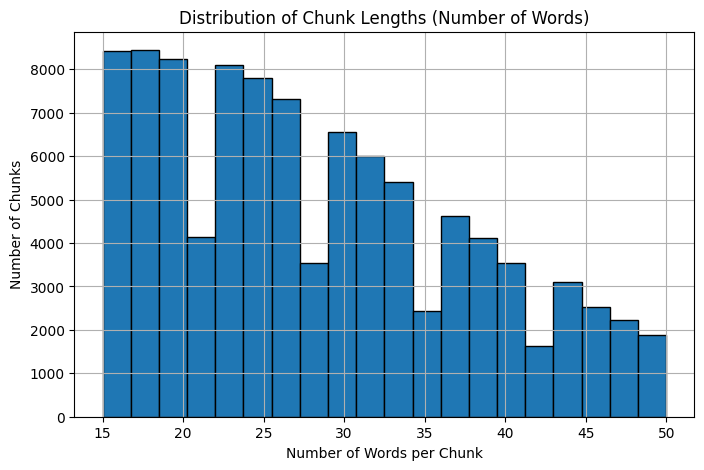

In [10]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(list_len, bins=20, edgecolor='black')

plt.title('Distribution of Chunk Lengths (Number of Words)')
plt.xlabel('Number of Words per Chunk')
plt.ylabel('Number of Chunks')
plt.grid(True)
plt.show()


In [11]:
import random
import string

# 1. 
def replace_char_in_word(sentence, rate):
    words = sentence.split()
    idx_error = []
    for i in range(len(words)):
        word = words[i]
        if random.random() < rate and len(word) > 0:
            idx = random.randint(0, len(word)-1)
            new_char = random.choice(string.ascii_letters)
            words[i] = word[:idx] + new_char + word[idx+1:]
            idx_error.append(i)
    return ' '.join(words), idx_error

# 2. 
def upper_case_word(sentence, rate):
    words = sentence.split()
    idx_error = []
    for i in range(len(words)):
        if random.random() < rate:
            words[i] = words[i].upper()
            idx_error.append(i)
    return ' '.join(words), idx_error

# 3.
def insert_char_in_word(sentence, rate):
    words = sentence.split()
    idx_error = []
    for i in range(len(words)):
        word = words[i]
        if random.random() < rate:
            idx = random.randint(0, len(word))  # insert trước/sau
            insert_char = random.choice(string.ascii_letters)
            words[i] = word[:idx] + insert_char + word[idx:]
            idx_error.append(i)
    return ' '.join(words), idx_error

# 4. 
def delete_char_in_word(sentence, rate):
    words = sentence.split()
    idx_error = []
    for i in range(len(words)):
        word = words[i]
        if random.random() < rate and len(word) > 1:
            idx = random.randint(0, len(word)-1)
            words[i] = word[:idx] + word[idx+1:]
            idx_error.append(i)
    return ' '.join(words), idx_error

# 5. 
def swap_char_in_word(sentence, rate):
    words = sentence.split()
    idx_error = []
    for i in range(len(words)):
        word = words[i]
        if random.random() < rate and len(word) > 1:
            idx1, idx2 = random.sample(range(len(word)), 2)
            word = list(word)
            word[idx1], word[idx2] = word[idx2], word[idx1]
            words[i] = ''.join(word)
            idx_error.append(i)
    return ' '.join(words), idx_error


In [12]:
import pandas as pd
import re
from tqdm import tqdm

def create_error_dataset(
    sentences,
    error_rate=0.01,
    error_module=None,
    num_sentences=5000,
    output_csv="output.csv"
):
    data = {
        'ground_truth': [],
        'corrupted': [],
        'mask': []
    }

    counter = 0
    for line in tqdm(sentences):
        if counter >= num_sentences:
            break

        line = line.strip()
        if not line:
            continue

        tokens = re.findall(r'\w+|[^\w\s]', line)
        line_clean = " ".join(tokens)

        if '. ' in line_clean:
            continue

        corrupted_line = line_clean
        word_level_errors = set()  

        for func in error_module:
            corrupted_line, idx_err = func(corrupted_line, error_rate)
            word_level_errors.update(idx_err)

        clean_words = line_clean.split()
        corrupted_words = corrupted_line.split()

        if len(clean_words) != len(corrupted_words):
            continue

        mask = [0] * len(corrupted_words)
        for idx in word_level_errors:
            if 0 <= idx < len(mask):
                mask[idx] = 1

        data['ground_truth'].append(line_clean)
        data['corrupted'].append(corrupted_line)
        data['mask'].append(''.join(map(str, mask)))

        counter += 1

    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False, encoding='utf-8-sig')
    print(f"✅ Đã lưu {len(df)} câu vào {output_csv}")


In [13]:

error_functions = [
    replace_char_in_word,
    upper_case_word,
    insert_char_in_word,
    delete_char_in_word,
    swap_char_in_word
]


create_error_dataset(
    chunks,
    error_rate=0.015,        
    error_module=error_functions,
    num_sentences=100000,
    output_csv="error_dataset.csv"
)


100%|██████████| 100000/100000 [00:06<00:00, 15579.01it/s]


✅ Đã lưu 100000 câu vào error_dataset.csv
